In [2]:
from pycisTopic.cistopic_class import create_cistopic_object_from_fragments
import pycisTopic as pcT
import polars as pl
import os
import scanpy as sc
import pickle

/home/derkelly/miniconda3/envs/scenicplus/lib/python3.11/site-packages/pycisTopic/__init__.py:3: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [3]:
import scenicplus

## Test creating cisTopic object

In [3]:
fragments_dict = {"DNT": "write/fragments_output/fragmentsDNT.bed.gz",
                  "MAIT": "write/fragments_output/fragmentsMAIT.bed.gz"}

In [4]:
path_to_regions = "write/peaks/split/peaks_ALL_summits.500bp.filt.merge.max.bed"
path_to_blacklist = "scenicplus/data/hg38-blacklist.v2.bed.gz"
pycistopic_qc_output_dir = "scenicplus/data/out/qc"

In [10]:
cistopic_obj_list = []
for sample_id in fragments_dict:
    cistopic_obj = create_cistopic_object_from_fragments(
        path_to_fragments = fragments_dict[sample_id],
        path_to_regions = path_to_regions,
        path_to_blacklist = path_to_blacklist,
        n_cpu = 1,
        project = sample_id,
        split_pattern = '-'
    )
    cistopic_obj_list.append(cistopic_obj)

2025-07-26 13:24:48,607 cisTopic     INFO     Reading data for DNT
2025-07-26 13:24:51,380 cisTopic     INFO     Counting number of unique fragments (Unique_nr_frag)
2025-07-26 13:24:51,492 cisTopic     INFO     Counting fragments in regions
2025-07-26 13:24:51,971 cisTopic     INFO     Creating fragment matrix
2025-07-26 13:24:52,199 cisTopic     INFO     Converting fragment matrix to sparse matrix
2025-07-26 13:24:52,236 cisTopic     INFO     Removing blacklisted regions
2025-07-26 13:24:52,615 cisTopic     INFO     Creating CistopicObject
2025-07-26 13:24:52,707 cisTopic     INFO     Done!
2025-07-26 13:24:52,715 cisTopic     INFO     Reading data for MAIT
2025-07-26 13:25:49,371 cisTopic     INFO     Counting number of unique fragments (Unique_nr_frag)
2025-07-26 13:26:01,112 cisTopic     INFO     Counting fragments in regions
2025-07-26 13:26:40,642 cisTopic     INFO     Creating fragment matrix
2025-07-26 13:27:09,403 cisTopic     INFO     Converting fragment matrix to sparse mat

In [71]:
cistopic_obj = pcT.cistopic_class.merge(cistopic_obj_list)

2025-07-26 17:12:52,709 cisTopic     INFO     cisTopic object 1 merged


In [14]:
cistopic_obj.cell_names

['MRA60:TCAGCGATCCTTGCGT-1-DNT___DNT',
 'MRA16:ATTTGCGCACAGCCAT-1-DNT___DNT',
 'MRA38:GGCTTAAGTTCCTGTG-1-DNT___DNT',
 'MRA50:GCAATGAAGTAAGAAC-1-DNT___DNT',
 'MRA49:GCTCTGTTCGATTCTT-1-DNT___DNT',
 'MRA63:TACGCTTGTTCAAGCA-1-DNT___DNT',
 'MRA14:TTTCAGTTCGTGCTAG-1-DNT___DNT',
 'MRA45:TCGATTAAGGTCATTA-1-DNT___DNT',
 'MRA41:CTGACCAAGGAAGTAT-1-DNT___DNT',
 'MRA47:TCACTGACATCCTGAA-1-DNT___DNT',
 'MRA52:AACCTTGCATGCATAT-1-DNT___DNT',
 'MRA38:GCGATATTCCCGTTTA-1-DNT___DNT',
 'MRA50:GTTAGGCGTTTAGCTC-1-DNT___DNT',
 'MRA22:CGCATTACAAGGAATC-1-DNT___DNT',
 'MRA37:TGCGCAGGTGCCTCAC-1-DNT___DNT',
 'MRA58:AGGTTGCGTGCTCCGT-1-DNT___DNT',
 'MRA57:TCTCAATTCTTGCAAA-1-DNT___DNT',
 'MRA58:CAGATTCAGCTGTAAC-1-DNT___DNT',
 'MRA17:TCCTTAGTCGAGGAAC-1-DNT___DNT',
 'MRA56:CGTGCTGCATGTCAAT-1-DNT___DNT',
 'MRA54:TTGTTGTTCTCCTCTT-1-DNT___DNT',
 'MRA43:GGCATTGTCAGGTCCA-1-DNT___DNT',
 'MRA27:ATTGAAGCACTTGTTC-1-DNT___DNT',
 'MRA57:CCTTTAGTCCTTAAGA-1-DNT___DNT',
 'MRA41:GTTTAACCATTGGGAG-1-DNT___DNT',
 'MRA21:ACCACACCAGGAATCG-

## Preprocess RNA data for SCENIC+

In [21]:
rna = sc.read_h5ad("write/MR_all_raw.h5ad")

In [26]:
spectra = sc.read_h5ad("write/MR_all.spectra_in.h5ad", backed='r')

In [28]:
# subset to filtered cells
rna = rna[spectra.obs_names,:]

In [32]:
# copy the covariate information form spectra (includes cell types)
rna.obs = spectra.obs

In [38]:
# format cell IDs so they will match with ATAC data (will include cytopus names)
rna.obs_names = ["{}-{}___{}".format(x,y,y) for x,y in zip(rna.obs_names, rna.obs['cytopus_names'])]

In [40]:
# follow normalization pipeline from https://scenicplus.readthedocs.io/en/latest/human_cerebellum_scRNA_pp.html
rna.raw = rna
sc.pp.normalize_total(rna, target_sum=1e4)
sc.pp.log1p(rna)
sc.pp.highly_variable_genes(rna, min_mean=0.0125, max_mean=3, min_disp=0.5)
rna = rna[:, rna.var.highly_variable]
sc.pp.scale(rna, max_value=10)

/home/derkelly/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
sc.tl.pca(rna)

/home/derkelly/miniconda3/envs/scenicplus/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


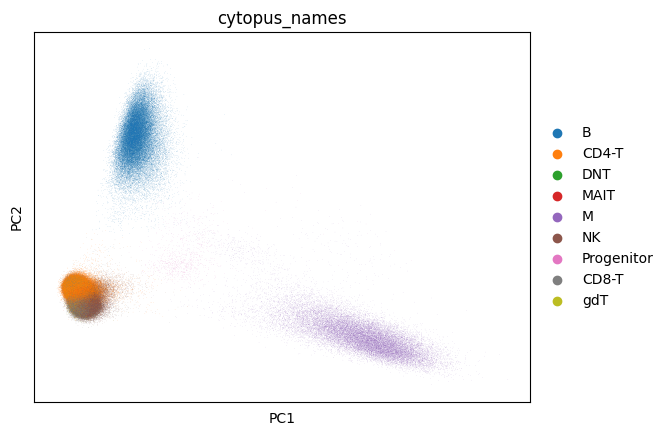

In [49]:
sc.pl.pca(rna, color = "cytopus_names")

In [44]:
sc.pp.neighbors(rna)

/home/derkelly/miniconda3/envs/scenicplus/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
sc.tl.umap(rna)

In [ ]:
sc.pl.umap(rna[rna.obs['Ethnicity']=="Tikari"], color = ["FCluster_names","COND"])
sc.pl.umap(rna[rna.obs['Ethnicity']=="Fulani"], color = ["FCluster_names","COND"])

In [52]:
rna.write("write/MR_all.scenic_in.h5ad")

## Test adding metadata to cisTopic object and writing

In [4]:
rna = sc.read_h5ad("write/MR_all.scenic_in.h5ad")

In [72]:
cols_keep = ['donor_id','TID','FID','BATCH', 'COND', 'SEX', 'AGE', 'Ethnicity', 'FCluster_names','Cluster_names', 'SCluster_names', 'cytopus_names']
cistopic_obj.add_cell_data(rna.obs[cols_keep])

In [73]:
cistopic_obj.cell_data

,cisTopic_nr_frag,cisTopic_log_nr_frag,cisTopic_nr_acc,cisTopic_log_nr_acc,sample_id,Unique_nr_frag,barcode,donor_id,TID,FID,BATCH,COND,SEX,AGE,Ethnicity,FCluster_names,Cluster_names,SCluster_names,cytopus_names
MRA60:TCAGCGATCCTTGCGT-1-DNT___DNT,7116,3.852236,6161,3.789651,DNT,NaN,NaN,NWD544436,NWD544436,D1005,EBT26,LPS,F,34.0,Fulani,DN T cells:DN T cells,DN T cells,DN T cells,DNT
MRA16:ATTTGCGCACAGCCAT-1-DNT___DNT,12644,4.101884,10146,4.006295,DNT,NaN,NaN,NWD372040,NWD372040,D0907,EBT21,LPS,M,58.0,Tikari,DN T cells:DN T cells,DN T cells,DN T cells,DNT
MRA38:GGCTTAAGTTCCTGTG-1-DNT___DNT,6896,3.838597,5758,3.760272,DNT,NaN,NaN,NWD500021,NWD500021,D0814,EBT24,CTL,F,50.0,Fulani,DN T cells:DN T cells,DN T cells,DN T cells,DNT
MRA50:GCAATGAAGTAAGAAC-1-DNT___DNT,9241,3.965719,7475,3.873611,DNT,NaN,NaN,NWD684922,NWD684922,D1296,EBT25,CTL,F,28.0,Tikari,DN T cells:DN T cells,DN T cells,DN T cells,DNT
MRA49:GCTCTGTTCGATTCTT-1-DNT___DNT,10884,4.036789,8683,3.93867,DNT,NaN,NaN,NWD846462,NWD846462,D0840,EBT25,CTL,F,46.0,Fulani,DN T cells:DN T cells,DN T cells,DN T cells,DNT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MRA39:CCGTTAACAGGCTAAG-1-MAIT___MAIT,628,2.79796,609,2.784617,MAIT,NaN,NaN,NWD901514,NWD901514,D1325,EBT24,LPS,F,52.0,Tikari,MAIT cells:MAIT cells,MAIT cells,MAIT cells,MAIT
MRA42:GGACATAAGTTACTTC-1-MAIT___MAIT,348,2.541579,343,2.535294,MAIT,NaN,NaN,NWD922916,NWD922916,D0906,EBT24,CTL,M,48.0,Fulani,MAIT cells:MAIT cells,MAIT cells,MAIT cells,MAIT
MRA36:TAGGAACCACTTCACT-1-MAIT___MAIT,246,2.390935,245,2.389166,MAIT,NaN,NaN,NWD290147,NWD290147,D1072,EBT23,LPS,F,35.0,Fulani,MAIT cells:MAIT cells,MAIT cells,MAIT cells,MAIT
MRA25:CAGCTCAAGATTCCTT-1-MAIT___MAIT,378,2.577492,376,2.575188,MAIT,NaN,NaN,NWD166655,NWD166655,D0908,EBT22,CTL,F,54.0,Tikari,MAIT cells:MAIT cells,MAIT cells,MAIT cells,MAIT


In [60]:
pickle.dump(
    cistopic_obj,
    open("cistopic_obj.test.pkl", "wb")
)

In [6]:
rna.obs['cytopus_names'].value_counts(normalize=True)

CD4-T         0.559340
CD8-T         0.197070
NK            0.094767
B             0.081689
M             0.046577
gdT           0.012148
MAIT          0.006760
Progenitor    0.001570
DNT           0.000079
Name: cytopus_names, dtype: float64

In [8]:
0.55/0.08 * 13

89.375